In [31]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [32]:
def calcular_metricas(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    return metricas

In [33]:
df = pd.read_csv('../output/dataset_venta.csv')
df['fecha'] = pd.to_datetime(df['fecha'], format="%Y-%m-%d", errors='coerce')
df = df.groupby('fecha')['monto_recibido'].sum().reset_index()
df.rename(columns={'fecha':'ds','monto_recibido':'y'}, inplace=True)
df.head(10)

,ds,y
0,2019-01-07,5651.05
1,2019-01-08,4285.00
2,2019-01-09,15455.00
3,2019-01-10,5024.50
4,2019-01-11,6350.50
5,2019-01-12,2741.00
6,2019-01-14,4213.00
7,2019-01-15,3204.00
8,2019-01-16,3838.00
9,2019-01-17,4065.00


In [53]:
n = len(df)
train_size = int(n*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train)}")
print(f"Tamaño del conjunto de prueba: {len(test)}")
print(f"Fechas de entrenamiento: {train['ds'].min().date()} a {train['ds'].max().date()}")
print(f"Fechas de prueba: {test['ds'].min().date()} a {test['ds'].max().date()}")


Tamaño del conjunto de entrenamiento: 1544
Tamaño del conjunto de prueba: 386
Fechas de entrenamiento: 2019-01-07 a 2024-05-07
Fechas de prueba: 2024-05-08 a 2025-08-18


In [35]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode='multiplicative'
)
m.add_seasonality(name='mensual', period=30.5, fourier_order=5)
m.fit(train)

09:00:50 - cmdstanpy - INFO - Chain [1] start processing
09:00:50 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
future = m.make_future_dataframe(periods=len(test), freq='D')
forecast = m.predict(future)

predicciones = forecast.iloc[-len(test):]

In [37]:
calcular_metricas(test['y'].values, predicciones['yhat'].values)

,Métrica,Valor
0,MAE,661.63917
1,RMSE,863.553405
2,sMAPE,38.96%
3,MAPE,43.80%
4,R2,-0.28


In [38]:
line_real = dict(color='#000000', linewidth=1.2, label='Datos reales')
line_pred = dict(color='#1f77b4', linewidth=1.2, linestyle='--', label='Predicción')
fill_pred = dict(color='#1f77b4', alpha=0.1, label='Intervalo 95%')
grid_opts = dict(linestyle='--', alpha=0.25)

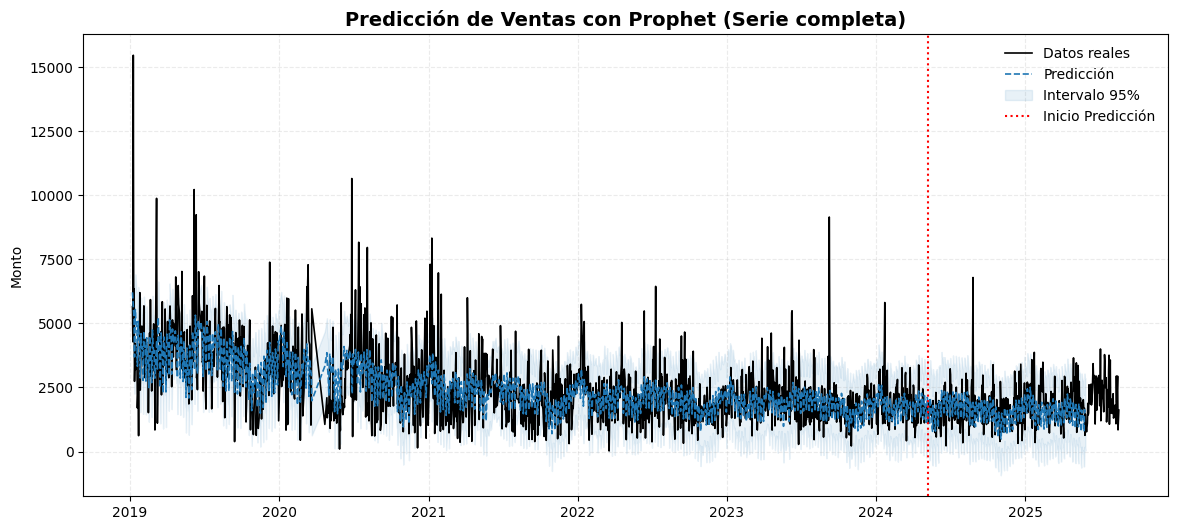

In [39]:
plt.figure(figsize=(14,6))
plt.plot(df['ds'], df['y'], **line_real)
plt.plot(forecast['ds'], forecast['yhat'], **line_pred)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], **fill_pred)
plt.axvline(df['ds'].iloc[train_size], color='red', linestyle=':', linewidth=1.5, label='Inicio Predicción')
plt.title('Predicción de Ventas con Prophet (Serie completa)', fontsize=14, weight='bold')
plt.ylabel('Monto')
plt.grid(**grid_opts)
plt.legend(frameon=False)
plt.show()

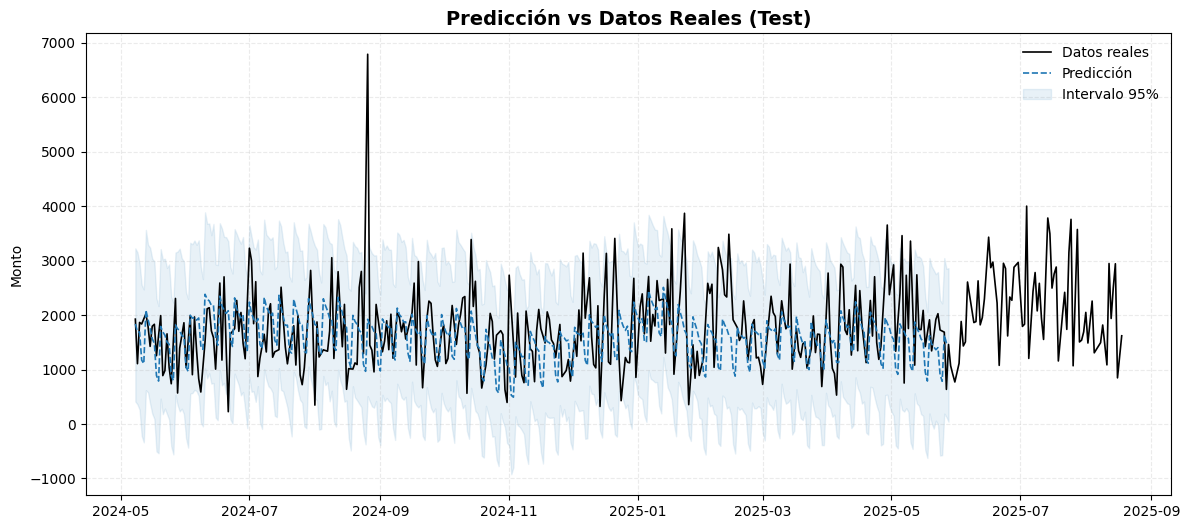

In [40]:
plt.figure(figsize=(14,6))
plt.plot(test['ds'], test['y'], **line_real)
plt.plot(predicciones['ds'], predicciones['yhat'], **line_pred)
plt.fill_between(predicciones['ds'], predicciones['yhat_lower'], predicciones['yhat_upper'], **fill_pred)
plt.title('Predicción vs Datos Reales (Test)', fontsize=14, weight='bold')
plt.ylabel('Monto')
plt.grid(**grid_opts)
plt.legend(frameon=False)
plt.show()

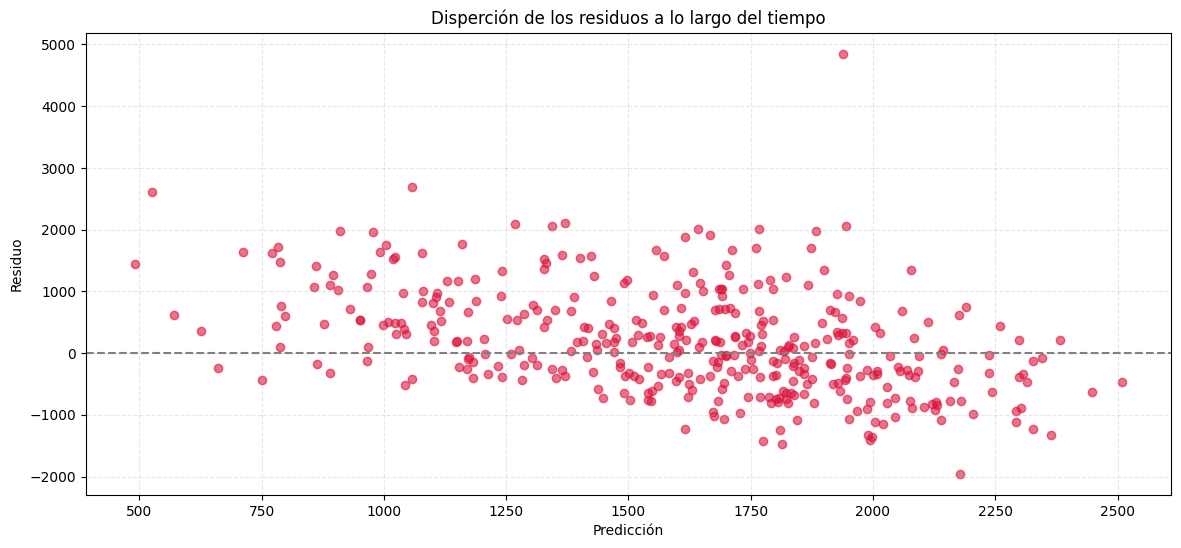

In [51]:
residuos = test['y'].values - predicciones['yhat'].values

plt.figure(figsize=(14,6))
plt.scatter(predicciones['yhat'], residuos, alpha=0.6, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Disperción de los residuos a lo largo del tiempo")
plt.xlabel('Predicción')
plt.ylabel('Residuo')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


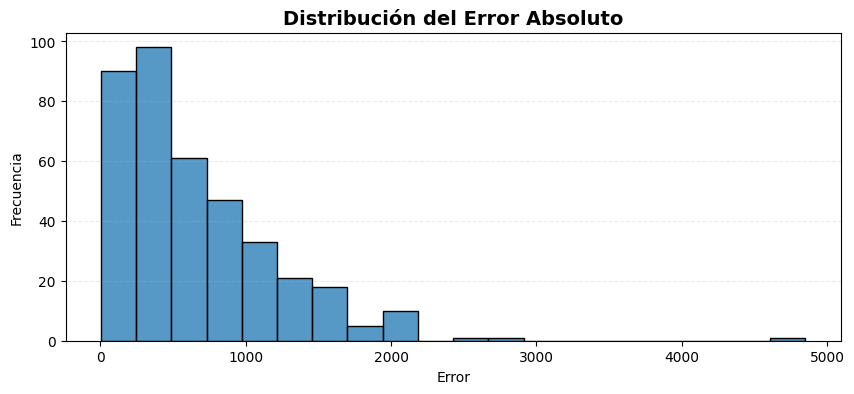

In [50]:
plt.figure(figsize=(10,4))
sns.histplot(abs(residuos), bins=20, color='#1f77b4', edgecolor='black')
plt.title('Distribución del Error Absoluto', fontsize=14, weight='bold')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

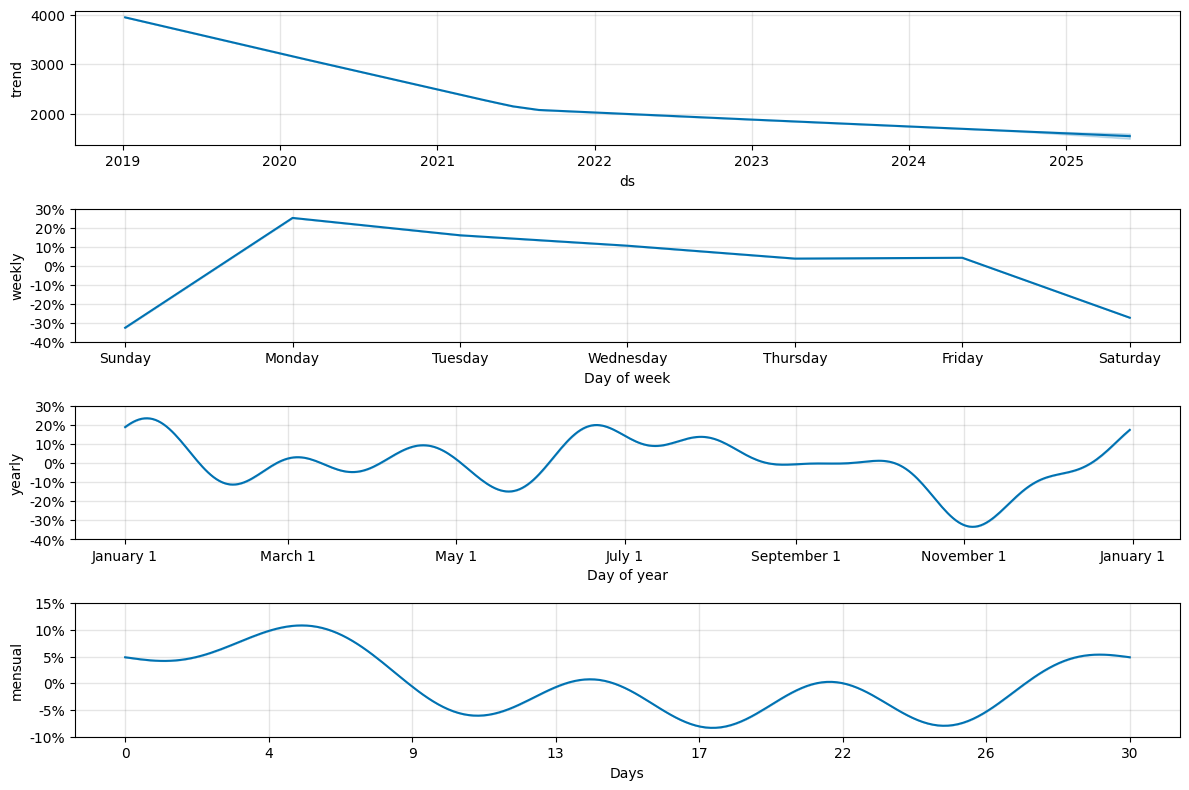

In [ ]:
# 1️⃣ Graficar descomposición
fig = m.plot_components(forecast)

# 2️⃣ Ajustes estéticos opcionales
fig.set_size_inches(12, 8)
plt.tight_layout()
plt.show()

In [44]:
resultado = pd.DataFrame({
    'ds': test['ds'].values,
    'real': test['y'].values,
    'yhat': predicciones['yhat'].values,
    'yhat_lower': predicciones['yhat_lower'].values,
    'yhat_upper': predicciones['yhat_upper'].values,
    'residuo': residuos
})
resultado.tail(10)

,ds,real,yhat,yhat_lower,yhat_upper,residuo
376,2025-08-05,1306.50,1621.740592,193.506927,3047.647242,-315.240592
377,2025-08-08,1493.00,1470.453160,21.241093,2895.075139,22.546840
378,2025-08-09,1817.50,1418.274262,-85.028048,2824.927325,399.225738
379,2025-08-11,1085.00,1363.503115,60.078639,2750.826810,-278.503115
380,2025-08-12,2946.75,1401.183637,-5.248567,2789.027478,1545.566363
381,2025-08-13,1937.00,907.056176,-579.927173,2275.372395,1029.943824
382,2025-08-14,2498.00,784.118249,-572.186141,2213.973185,1713.881751
383,2025-08-15,2942.00,1632.111033,190.020642,3047.111497,1309.888967
384,2025-08-16,846.50,1490.199498,128.053835,2849.591607,-643.699498
385,2025-08-18,1619.50,1454.443039,41.479417,2861.160645,165.056961


In [45]:
resultado.to_csv(f'../output/prediccion_prophet.csv', index=False)
print(f"✅ Archivo exportado: prediccion_prophet_diario_mejorado.csv")

✅ Archivo exportado: prediccion_prophet_diario_mejorado.csv
